In [1]:
import torch
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import perturbed_organics.utils as utils
import math


plt.rcParams.update({
    "text.usetex": False, 
    "font.family": "serif", 
    "font.serif": ["Computer Modern Roman", "DejaVu Serif", "Bitstream Vera Serif"],
    "mathtext.fontset": "cm"
})
cmap = 'plasma_r'

In [2]:
input_type = 'delocalized'
mu = "0.0"
mu_val = float(mu)

model_type = ''
# model_type = '_rectified'
# model_type = '_rectified_recurrence'

# folder_loc = f'/scratch/sr6364/perturbed_organics/data/adaptive_phase_diagram_100/{input_type}'
folder_loc = f'/scratch/sr6364/perturbed_organics/data/adaptive_phase_diagram_100_large_delta{model_type}/{input_type}'
folder_name = f'{input_type}_goe_symmetric_N_100_s_100_mu_{mu}_num_delta_200_num_input_200_num_trials_100_b0_1.0_b1_1.0_phase_diagram_log-scale'

path = os.path.join(folder_loc, folder_name)

In [3]:
# Load parameters from the JSON file
param_file_path = os.path.join(path, 'parameters.json')
with open(param_file_path, 'r') as f:
    params = json.load(f)

# Extract parameters
N = params['N']
num_tasks = params['num_tasks']
num_delta = params['num_delta']
num_input = params['num_input']
num_trials = params['num_trials']
delta_scale = params['delta_scale']
delta_range = np.array(params['delta_range'])
input_range = np.array(params['input_range'])

In [4]:
condition = torch.load(os.path.join(path, f'condition.pt'))
norm_fixed_point_y = torch.load(os.path.join(path, f'norm_fixed_point_y.pt'))
actual_fixed_point_y = torch.load(os.path.join(path, f'actual_fixed_point_y.pt'))
first_order_perturb_y = torch.load(os.path.join(path, f'first_order_perturb_y.pt'))

In [5]:
bool_stable = torch.where(condition == 2, True, False)
# bool_limit_cycle = torch.where((condition == 0) | (condition == 3), True, False)
bool_limit_cycle = torch.where(condition == 3, True, False)
bool_not_converged = torch.where(condition == 0, True, False)
bool_unstable = torch.where(condition == 1, True, False)

In [6]:
# Proceed with plotting or further analysis
percent_stable = bool_stable.float().mean(dim=2) * 100
percent_notstable = 100 - percent_stable

percent_limit_cycle = bool_limit_cycle.float().mean(dim=2) * 100

percent_unstable = bool_unstable.float().mean(dim=2) * 100
percent_not_converged = bool_not_converged.float().mean(dim=2) * 100

In [7]:
# analytical prediction from perturbation theory
num_points_to_exclude = 3
idx = 0
norm_sol_idx = []
for input_norm in input_range:
    z = utils.make_input_drive(N=N, input_type=params['model_name'], input_norm=input_norm)
    norm_eqn = torch.sqrt(z ** 2 / (params['sigma']**2 + torch.norm(z) ** 2))
    norm_sol_idx.append(norm_eqn[idx].item())
norm_sol_idx = np.array(norm_sol_idx)

# analytical solution for the mean of the fixed point
G = (1 - np.sqrt(params['sigma'] ** 2 + input_range ** 2)) / (params['sigma'] ** 2 + input_range ** 2)
analytical_mean = norm_sol_idx + mu_val * input_range * G * (1 - input_range ** 2 / (params['sigma'] ** 2 + input_range ** 2)) / np.sqrt(N)


delta_c =  math.sqrt(2 * N) * analytical_mean / (G * input_range)
delta_c = delta_c[:-num_points_to_exclude]
new_input_norm = input_range[:-num_points_to_exclude]

In [8]:
folder_loc = f'../figures/mu_{mu}/fig_phase_diagram{model_type}_{input_type}_extra'
os.makedirs(folder_loc, exist_ok=True)

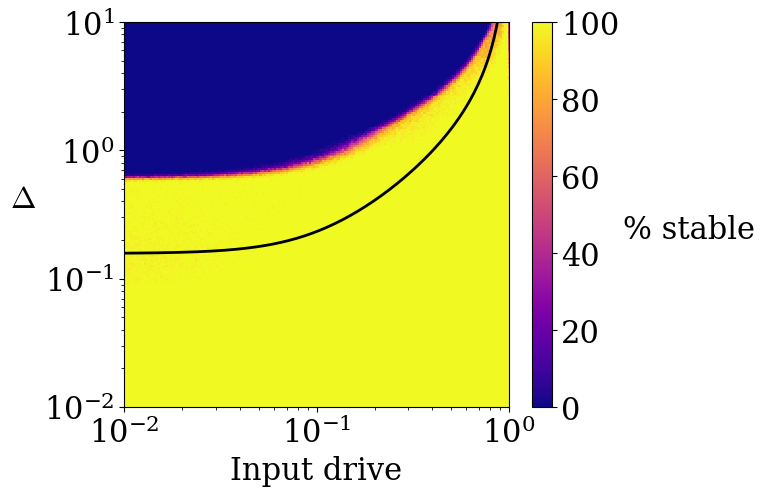

In [9]:
plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=0, vmax=100, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, percent_stable, cmap='plasma', norm=norm)
plt.plot(new_input_norm, delta_c, color='k', linewidth=2.0, label=r'$\Delta_c$')

colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
colorbar.ax.set_ylabel(r"% stable", fontsize=22, rotation=0, labelpad=50)
plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

# file_name = f'percent_stable_{input_type}'
# file_save_path = os.path.join(folder_loc, file_name)

# plt.tight_layout()
# plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
# plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
# plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)
plt.show()

In [10]:
input_idx1 = 0
delta_values1 = percent_stable[:, input_idx1]

# find the first index at which percent stable become 0
for i in range(len(delta_values1)):
    if delta_values1[i] == 0:
        first_zero_index = i
        break
else:
    first_zero_index = len(delta_values1)

print(f"First index where percent stable becomes 0: {first_zero_index}")
# Extract the delta values and corresponding percent stable values
delta_values1 = delta_range[first_zero_index]
print(delta_values1)

First index where percent stable becomes 0: 121
0.6669919663030122


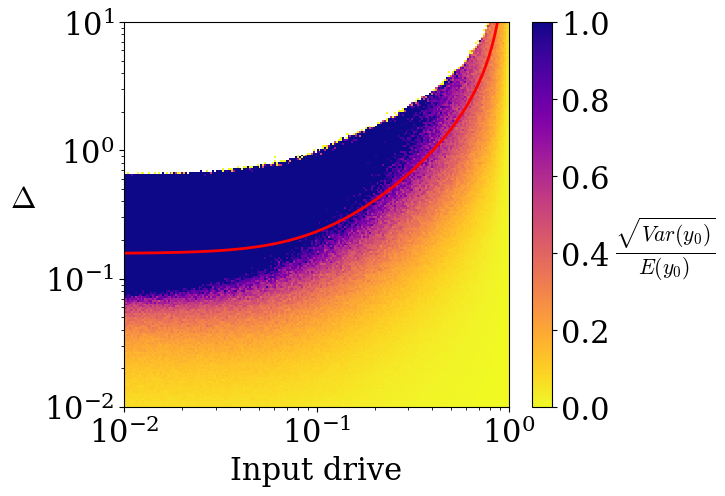

In [11]:
plt.figure(figsize=(7.5, 5))

idx = 0

norm = mcolors.Normalize(vmin=0, vmax=1, clip=True)

# calculate the avg ratio of deviation from norm fixed point for y
# y1_squared_norm = torch.norm(norm_fixed_point_y - actual_fixed_point_y, dim=3) ** 2 # deviation from the fixed point
# y0_squared_norm = torch.norm(norm_fixed_point_y, dim=3) ** 2
# y_ratio = y1_squared_norm / y0_squared_norm
# y_ratio_mean = torch.sqrt(torch.mean(y_ratio, dim=2))
# y_ratio_mean = torch.sqrt(torch.nanmean(y_ratio, dim=2))

# code for the standard deviation over mean criterion
y_val = actual_fixed_point_y[:, :, :, idx]
y_val_std = utils.nanstd(y_val, dim=2)
# y_val_std = np.nanstd(y_val, axis=2)
y_val_mean = torch.nanmean(y_val, dim=2)
y_ratio_mean = torch.abs(y_val_std / y_val_mean)

mesh = plt.pcolormesh(input_range, delta_range, y_ratio_mean, cmap=cmap, norm=norm)
plt.plot(new_input_norm, delta_c, color='red', linewidth=2.0, label=r'$\Delta_c$')

colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
# colorbar.ax.set_ylabel(r"$\frac{||\mathbf{y}-\mathbf{y}_0||}{||\mathbf{y}_0||}$", fontsize=22, rotation=0, labelpad=40)
colorbar.ax.set_ylabel(r"$\frac{\sqrt{Var(y_0)}}{E(y_0)}$", fontsize=22, rotation=0, labelpad=40)
plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
# plt.title("Actual Mean Ratio of Norm Difference for y", fontsize=22)
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

# file_name = f'norm_ratio_{input_type}'
# file_save_path = os.path.join(folder_loc, file_name)

# plt.tight_layout()
# plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
# plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
# plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)
plt.show()

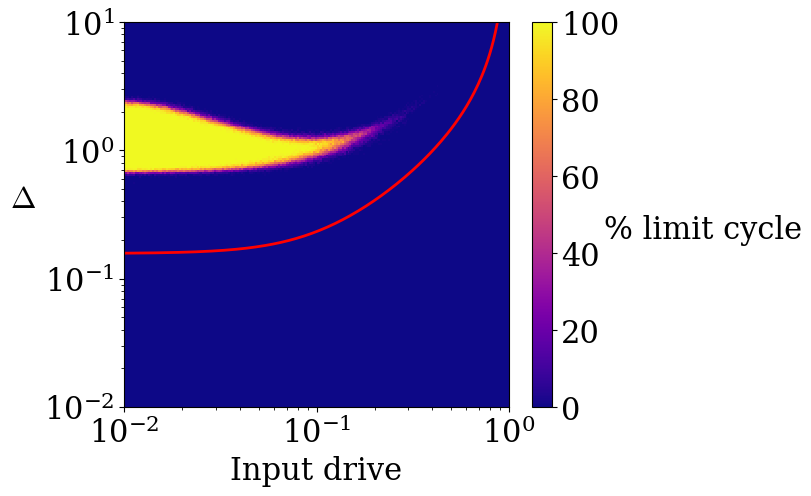

In [12]:
# We plot the percent of limit cycles detected

plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=0, vmax=100, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, percent_limit_cycle, cmap='plasma', norm=norm)
plt.plot(new_input_norm, delta_c, color='r', linewidth=2.0, label=r'$\Delta_c$')

colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
colorbar.ax.set_ylabel(r"% limit cycle", fontsize=22, rotation=0, labelpad=60)
plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)


ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

# file_name = f'percent_limit_cycle_{input_type}'
# file_save_path = os.path.join(folder_loc, file_name)

# plt.tight_layout()
# plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
# plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
# plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)
plt.show()


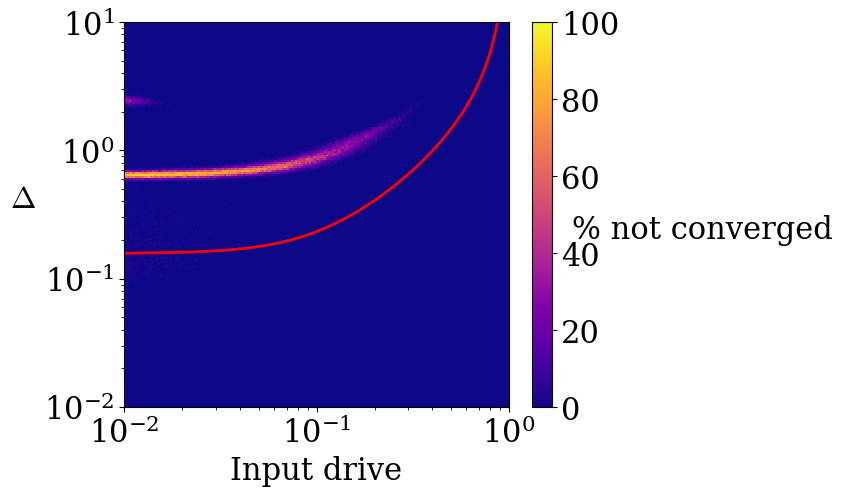

In [13]:
# We plot the percent of simulations not converged

plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=0, vmax=100, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, percent_not_converged, cmap='plasma', norm=norm)
plt.plot(new_input_norm, delta_c, color='r', linewidth=2.0, label=r'$\Delta_c$')

colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
colorbar.ax.set_ylabel(r"% not converged", fontsize=22, rotation=0, labelpad=60)
plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)


ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

# file_name = f'percent_not_converged_{input_type}'
# file_save_path = os.path.join(folder_loc, file_name)

# plt.tight_layout()
# plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
# plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
# plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()


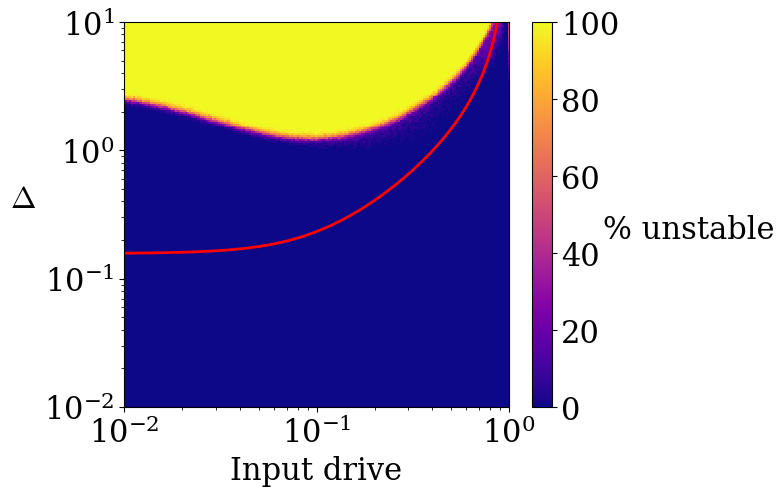

In [14]:
# We plot the percent of unstable detected

plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=0, vmax=100, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, percent_unstable, cmap='plasma', norm=norm)
plt.plot(new_input_norm, delta_c, color='r', linewidth=2.0, label=r'$\Delta_c$')


colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
colorbar.ax.set_ylabel(r"% unstable", fontsize=22, rotation=0, labelpad=50)
plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)


ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

# file_name = f'percent_unstable_{input_type}'
# file_save_path = os.path.join(folder_loc, file_name)

# plt.tight_layout()
# plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
# plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
# plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()


### Dicover the pattern the about center manifold using the eigenvalues of the jacobian matrix

In [15]:
eigvals = torch.load(os.path.join(path, f'eigvals_J.pt'))
print(eigvals.shape) # num_delta, num_input, num_trials, 2*N)

torch.Size([200, 200, 100, 200])


In [16]:
# fit and find the intersection of mean and variance
stability_criterion_percent = 0.99
fitted_intersection = np.zeros((len(delta_range)))
idx = 0

for i, delta_val in enumerate(delta_range):
    actual_fp_y = actual_fixed_point_y[i, :, :, :]
    y_val = actual_fp_y[:, :, idx]

    y_val_mean = torch.nanmean(y_val, dim=1)
    y_val_std = utils.nanstd(y_val, dim=1)

    # check if unstable
    ratio_stable = torch.sum(~torch.isnan(y_val), dim=1) / num_trials
    mask = (ratio_stable > stability_criterion_percent).cpu().numpy()

    # fit the mean
    x_vals = np.array(input_range)[mask].astype(np.float64)
    y_vals = np.array(y_val_mean[mask]).astype(np.float64)

    if x_vals.size == 0 or y_vals.size == 0:
        fitted_intersection[i] = np.nan
        continue
    coeffs = np.polyfit(np.log10(x_vals), y_vals, deg=5)
    poly_func = np.poly1d(coeffs)
    x_fit_mean = np.logspace(np.log10(x_vals.min()), np.log10(x_vals.max()), 200)
    y_fit_mean = poly_func(np.log10(x_fit_mean))

    # fit the std
    x_vals = np.array(input_range)[mask].astype(np.float64)
    y_vals = np.array(y_val_std[mask]).astype(np.float64)
    coeffs = np.polyfit(np.log10(x_vals), y_vals, deg=5)
    poly_func = np.poly1d(coeffs)
    x_fit_std = np.logspace(np.log10(x_vals.min()), np.log10(x_vals.max()), 200)
    y_fit_std = poly_func(np.log10(x_fit_std))

    # find the intersection
    diff = y_fit_mean - y_fit_std

    # Find indices where the difference changes sign.
    sign_change_idxs = np.where(np.diff(np.sign(diff)))[0]

    if sign_change_idxs.size > 0:
        # Take the first crossing.
        idx1 = sign_change_idxs[0]
        # Define the two x values and the corresponding differences.
        x0, x1 = x_fit_mean[idx1], x_fit_mean[idx1 + 1]
        d0, d1 = diff[idx1], diff[idx1 + 1]
        
        # Linear interpolation to estimate the intersection.
        t = -d0 / (d1 - d0)
        x_intersect = x0 + t * (x1 - x0)
        
        fitted_intersection[i] = x_intersect
    else:
        fitted_intersection[i] = np.nan

/tmp/ipykernel_3806100/2874953876.py:24: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(np.log10(x_vals), y_vals, deg=5)
/tmp/ipykernel_3806100/2874953876.py:32: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(np.log10(x_vals), y_vals, deg=5)
/tmp/ipykernel_3806100/2874953876.py:24: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(np.log10(x_vals), y_vals, deg=5)
/tmp/ipykernel_3806100/2874953876.py:32: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(np.log10(x_vals), y_vals, deg=5)
/tmp/ipykernel_3806100/2874953876.py:24: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(np.log10(x_vals), y_vals, deg=5)
/tmp/ipykernel_3806100/2874953876.py:32: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(np.log10(x_vals), y_vals, deg=5)
/tmp/ipykernel_3806100/2874953876.py:24: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(np.log10(x_vals), y_vals, deg=5)

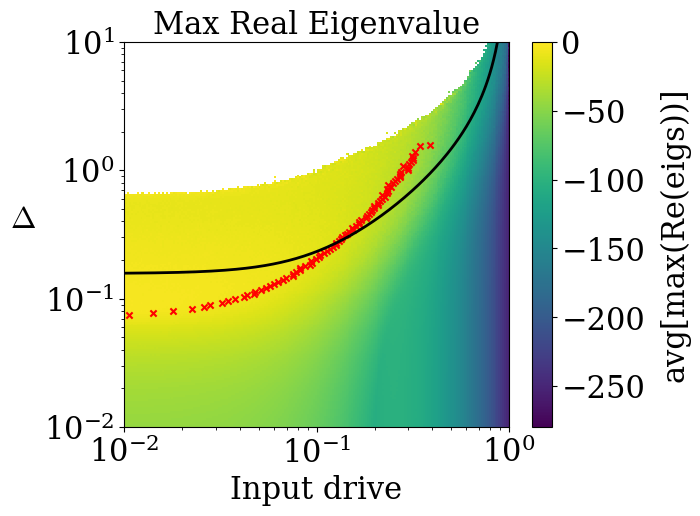

In [17]:
# Compute the maximum real part for each trial (max over eigenvalue index)
max_real_each_trial = torch.max(eigvals.real, dim=3)[0]  # shape: (num_delta, num_input, num_trials)

# Average over trials to get a 2D phase diagram (if desired)
max_real_avg = torch.nanmean(max_real_each_trial, dim=2)      # shape: (num_delta, num_input)
# calcluate the standard deviation
max_real_std = utils.nanstd(max_real_each_trial, dim=2)

# Convert to NumPy for plotting
max_real_avg_np = max_real_avg.numpy()
max_real_std_np = max_real_std.numpy()

# Determine vmin and vmax ignoring NaN values
vmin = np.nanmin(max_real_avg_np)
vmax = np.nanmax(max_real_avg_np)

# Plot the phase diagram for max(real(eigenvalues)) using a sequential colormap ("viridis")
plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=vmin, vmax=0.0, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, max_real_avg_np, cmap='viridis', norm=norm)
plt.plot(new_input_norm, delta_c, color='k', linewidth=2.0, label=r'$\Delta_c$')
colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
colorbar.set_label('avg[max(Re(eigs))]', fontsize=22, rotation=90, labelpad=10)

# plot the intersection of the curves from fig3
plt.scatter(fitted_intersection, delta_range, color='r', s=20, marker='x')

# plt.plot(fitted_intersection, delta_range, color='red', linewidth=2.0)

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("Max Real Eigenvalue", fontsize=22)

ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

# file_name = f'avg_eigvals_{input_type}'
# file_save_path = os.path.join(folder_loc, file_name)

# plt.tight_layout()
# plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
# plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
# plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()


/tmp/ipykernel_3806100/2218667504.py:5: RuntimeWarning: All-NaN slice encountered
  max_real_max = np.nanmax(max_real_each_trial.numpy(), axis=2)


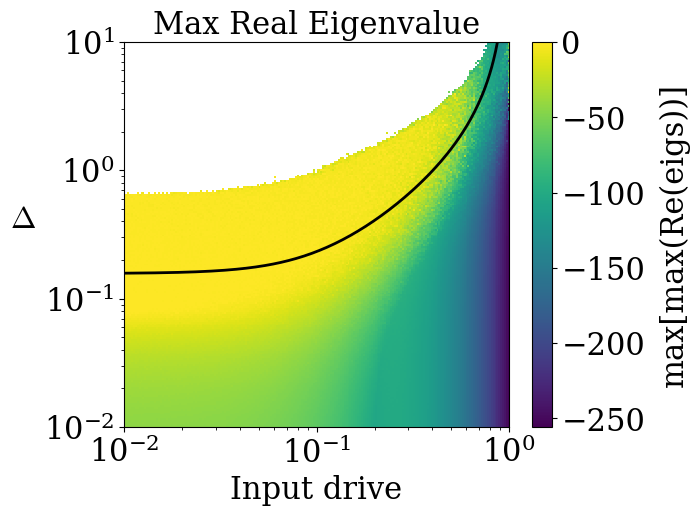

In [18]:
# Compute the maximum real part for each trial (max over eigenvalue index)
max_real_each_trial = torch.max(eigvals.real, dim=3)[0]  # shape: (num_delta, num_input, num_trials)

# find the max of the trials
max_real_max = np.nanmax(max_real_each_trial.numpy(), axis=2)

# Determine vmin and vmax ignoring NaN values
vmin = np.nanmin(max_real_max)
vmax = np.nanmax(max_real_max)

# Plot the phase diagram for max(real(eigenvalues)) using a sequential colormap ("viridis")
plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=vmin, vmax=0.0, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, max_real_max, cmap='viridis', norm=norm)
plt.plot(new_input_norm, delta_c, color='k', linewidth=2.0, label=r'$\Delta_c$')
colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
colorbar.set_label('max[max(Re(eigs))]', fontsize=22, rotation=90, labelpad=10)

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("Max Real Eigenvalue", fontsize=22)

ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

# file_name = f'max_eigvals_{input_type}'
# file_save_path = os.path.join(folder_loc, file_name)

# plt.tight_layout()
# plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
# plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
# plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()


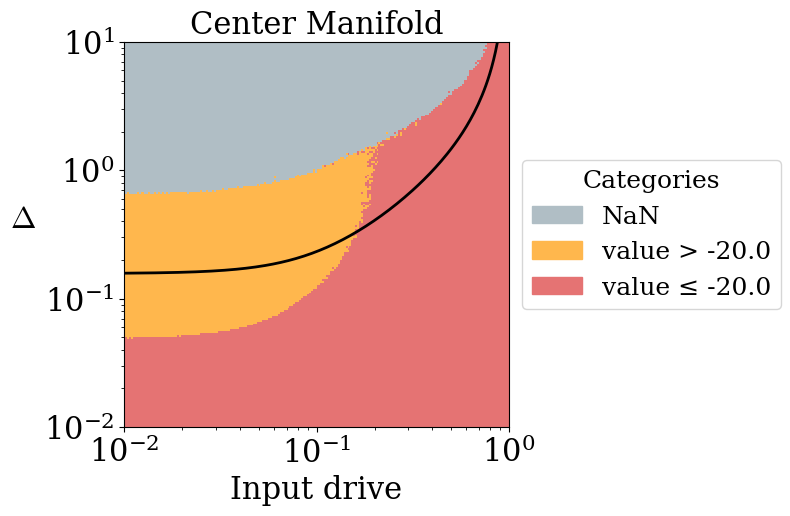

In [19]:
# Define hex codes for the three colors (change these as needed)
color_nan = "#B0BEC5"    # For NaN values
color_class1 = "#FFB74D" # For values > threshold (and < 0)
color_class2 = "#E57373" # For values ≤ threshold

# Define the threshold for center manifold (adjust as needed)
threshold = - 20.0

qty_to_check = max_real_avg_np
# qty_to_check = max_real_max
# qty_to_check = max_real_avg_np + max_real_std_np

# Create a classification array with the same shape as qty_to_check
# We assign:
#   0 for NaN values,
#   1 for values in (threshold, 0),
#   2 for values less than or equal to threshold.

classification = np.zeros_like(qty_to_check, dtype=int)
# Mark NaN values
nan_mask = np.isnan(qty_to_check)
classification[nan_mask] = 0  
# For non-NaN values, assign classes:
non_nan = ~nan_mask
# Class 1: threshold < value < 0
mask1 = (qty_to_check > threshold) & non_nan
classification[mask1] = 1
# Class 2: value ≤ threshold
mask2 = (qty_to_check <= threshold) & non_nan
classification[mask2] = 2

# Create a discrete colormap using the defined colors
from matplotlib.colors import ListedColormap
colors = [color_nan, color_class1, color_class2]
discrete_cmap = ListedColormap(colors)

# Plot the new classification
plt.figure(figsize=(7.5, 5))
mesh = plt.pcolormesh(input_range, delta_range, classification, cmap=discrete_cmap, shading='auto', vmin=0, vmax=2)
plt.plot(new_input_norm, delta_c, color='k', linewidth=2.0, label=r'$\Delta_c$')
plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("Center Manifold", fontsize=22)

# Create a custom legend with the legend positioned outside the figure
import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(color=color_nan, label='NaN'),
    mpatches.Patch(color=color_class1, label=f'value > {threshold}'),
    mpatches.Patch(color=color_class2, label=f'value ≤ {threshold}')
]
plt.legend(handles=legend_handles, fontsize=18, title="Categories", title_fontsize=18,
           loc='center left', bbox_to_anchor=(1, 0.5))

ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

# file_name = f'center_manifold_{input_type}'
# file_save_path = os.path.join(folder_loc, file_name)

# plt.tight_layout()
# plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
# plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
# plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()


A combined phase diagram

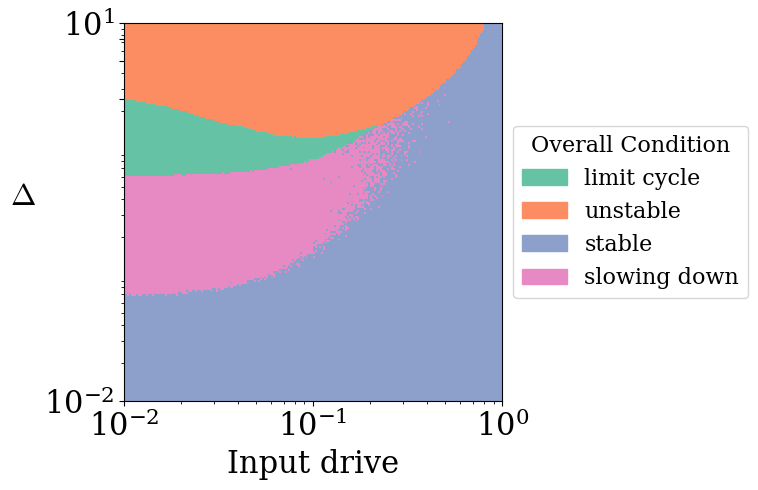

In [20]:
# -------------------------------------------------------------------------
# 1) Load your data (assuming you already have the variables in your workspace).
#    condition shape: (num_delta, num_input, num_trials)
#    eigvals   shape: (num_delta, num_input, num_trials, 2*N)
#    input_range, delta_range, etc.
# -------------------------------------------------------------------------
# For illustration, we assume you've already loaded:
#   condition, eigvals, input_range, delta_range, ...
#   from your code above.
#
# You can skip re-loading if they are already in memory.

# -------------------------------------------------------------------------
# 2) Define function to find the single "overall" condition via majority-vote
#    among the trials.
#    We treat condition=3 the same as 0 (both limit cycles).
# -------------------------------------------------------------------------
def majority_condition(conditions_1d):
    """
    Given a 1D array of trial conditions (length = num_trials),
    return the single integer condition by majority vote.
    Tie-break: pick the smallest condition ID among ties.

    We unify 3 -> 0 (both are 'limit cycle').
    """
    # Convert 3 -> 0 for counting
    conditions_unified = np.where(np.isin(conditions_1d, 3), 0, conditions_1d)

    unique_conds, counts = np.unique(conditions_unified, return_counts=True)

    # Find which condition has the maximum count
    max_count_index = np.argmax(counts)
    final_cond = unique_conds[max_count_index]
    return final_cond


# -------------------------------------------------------------------------
# 3) Compute (for each delta, input) the majority condition among the trials.
# -------------------------------------------------------------------------
num_delta, num_input, num_trials = condition.shape
final_condition_2d = np.zeros((num_delta, num_input), dtype=int)

for i_d in range(num_delta):
    for i_in in range(num_input):
        cond_1d = condition[i_d, i_in, :].cpu().numpy()
        c = majority_condition(cond_1d)
        final_condition_2d[i_d, i_in] = c  # 0, 1, or 2 by majority


# -------------------------------------------------------------------------
# 4) Among the "stable" final conditions (==2),
#    refine to condition=5 if the avg largest real eigenvalue among
#    *stable trials only* is > some threshold but still < 0
#    (i.e., negative but close to zero => "slowing down").
#
#    Adjust 'slowing_threshold' as desired.
# -------------------------------------------------------------------------
slowing_threshold = 1e-2  # example threshold for "slowing down"

# Get the real parts of eigenvalues: shape (num_delta, num_input, num_trials, 2*N)
eigvals_real = eigvals.real * 0.002

# For each (delta, input), find the *stable trials* among the 100
# and compute the max of the largest real eigenvalue in those stable trials.
for i_d in range(num_delta):
    for i_in in range(num_input):

        if final_condition_2d[i_d, i_in] == 2:
            # Identify stable trials at this point
            cond_1d = condition[i_d, i_in, :].cpu().numpy()
            stable_mask = (cond_1d == 2)

            if not np.any(stable_mask):
                # No truly stable trials => skip
                continue

            # Extract the real eigenvalues of stable trials
            these_eigs = eigvals_real[i_d, i_in, stable_mask, :]  # shape = (num_stable, 2*N)
            # largest real part per stable trial
            max_real_each_trial = np.nanmax(these_eigs, axis=1)       # shape = (num_stable,)
            max_real_each_trial[max_real_each_trial > 0] = np.nan

            # average largest real part
            max_real_max = np.nanmax(max_real_each_trial)

            # If it's "close to zero" but negative (>-0.02, say) => define condition=5
            if (np.abs(max_real_max) < slowing_threshold):
                final_condition_2d[i_d, i_in] = 5


# -------------------------------------------------------------------------
# 5) Plot a single phase diagram with these final conditions:
#    0 (limit cycle), 1 (unstable), 2 (stable), 5 (slowing down).
# -------------------------------------------------------------------------
# We'll create a discrete colormap. We only have 4 final categories in use:
#   {0, 1, 2, 5}, but we'll map them to 0, 1, 2, 3 in an integer array for pcolormesh.
# Define a small mapping dictionary:
cond_map = {0: 0, 1: 1, 2: 2, 5: 3}  # map to [0..3]

# Build an integer array for pcolormesh
plot_data = np.full_like(final_condition_2d, fill_value=-1, dtype=int)
for c_old, c_new in cond_map.items():
    plot_data[final_condition_2d == c_old] = c_new

# Define a discrete set of colors (4 categories).
# Adjust or pick whatever colors you prefer:
colors_list = [
    "#66c2a5",  # index 0 => condition 0 => limit cycle
    "#fc8d62",  # index 1 => condition 1 => unstable
    "#8da0cb",
    "#e78ac3"   # index 3 => condition 5 => slowing down (Orange)
]
cmap_discrete = mcolors.ListedColormap(colors_list)

# Create a figure
plt.figure(figsize=(7.5, 5))
mesh = plt.pcolormesh(
    input_range,
    delta_range,
    plot_data,
    cmap=cmap_discrete,
    shading='auto',
    vmin=0,  # must match min of mapped data
    vmax=len(colors_list)  # or 4
)

# If you have a known theoretical line to plot (e.g. delta_c),
# you can overlay it:
# plt.plot(new_input_norm, delta_c, color='k', linewidth=2.0, label=r'$\Delta_c$')

# Keep the same aspect ratio logic you used elsewhere:
ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

ax.set_yticks(np.linspace(delta_range[0], delta_range[-1], 5))

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

# Create a custom legend:
import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(color=colors_list[0], label="limit cycle"),    # Blue
    mpatches.Patch(color=colors_list[1], label="unstable"),        # Red
    mpatches.Patch(color=colors_list[2], label="stable"),          # Green
    mpatches.Patch(color=colors_list[3], label="slowing down"),    # Purple
]
plt.legend(
    handles=legend_handles,
    fontsize=16,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    title="Overall Condition",
    title_fontsize=16
)

plt.tight_layout()

# # Save if you like:
# file_name = "phase_diagram_overall_condition"
# file_save_path = os.path.join(folder_loc, file_name)

# plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
# plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
# plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()

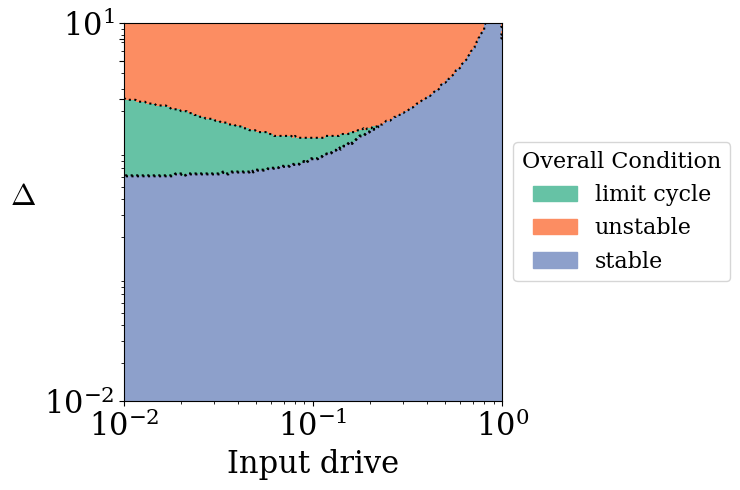

In [21]:
# Define the mapping dictionary: combine condition 2 and 5 into a single category.
cond_map = {0: 0, 1: 1, 2: 2, 5: 2}  # Both stable and slowing down are now 2

# Build an integer array for pcolormesh
plot_data = np.full_like(final_condition_2d, fill_value=-1, dtype=int)
for c_old, c_new in cond_map.items():
    plot_data[final_condition_2d == c_old] = c_new

# Example ColorBrewer "Set2" palette for 3 categories:
#   limit cycle => #66c2a5
#   unstable    => #fc8d62
#   stable      => #8da0cb
colors_list = [
    "#66c2a5",  # index 0 => condition 0 => limit cycle
    "#fc8d62",  # index 1 => condition 1 => unstable
    "#8da0cb"   # index 2 => condition 2 => stable
]
cmap_discrete = mcolors.ListedColormap(colors_list)
# delta_range = 2 * delta_range + 1
plt.figure(figsize=(7.5, 5))
mesh = plt.pcolormesh(
    input_range,
    delta_range,
    plot_data,
    cmap=cmap_discrete,
    shading='auto',
    vmin=0,
    vmax=len(colors_list)
)

X, Y = np.meshgrid(input_range, delta_range)

# Define the boundary levels between the discrete condition values.
# The boundaries between 0 and 1 is at 0.5, and between 1 and 2 is at 1.5.
boundary_levels = [0.5, 1.5]

# Plot the contour lines with a dotted line style.
plt.contour(X, Y, plot_data, levels=boundary_levels, colors='k', linestyles='dotted')

# (Your existing code for aspect ratio, axes limits, ticks, etc.)
ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

ax.set_yticks(np.linspace(delta_range[0], delta_range[-1], 5))
plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])
plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

# Create a custom legend with a single entry for "stable" (which includes slowing down).
import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(color=colors_list[0], label="limit cycle"),
    mpatches.Patch(color=colors_list[1], label="unstable"),
    mpatches.Patch(color=colors_list[2], label="stable")
]

plt.legend(
    handles=legend_handles,
    fontsize=16,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    title="Overall Condition",
    title_fontsize=16
)

plt.tight_layout()

# Save if you like:
# file_name = "phase_diagram_overall_condition"
# file_save_path = os.path.join(folder_loc, file_name)

# plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
# plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
# plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()


delta: 0.023816855519761582, input: 0.01


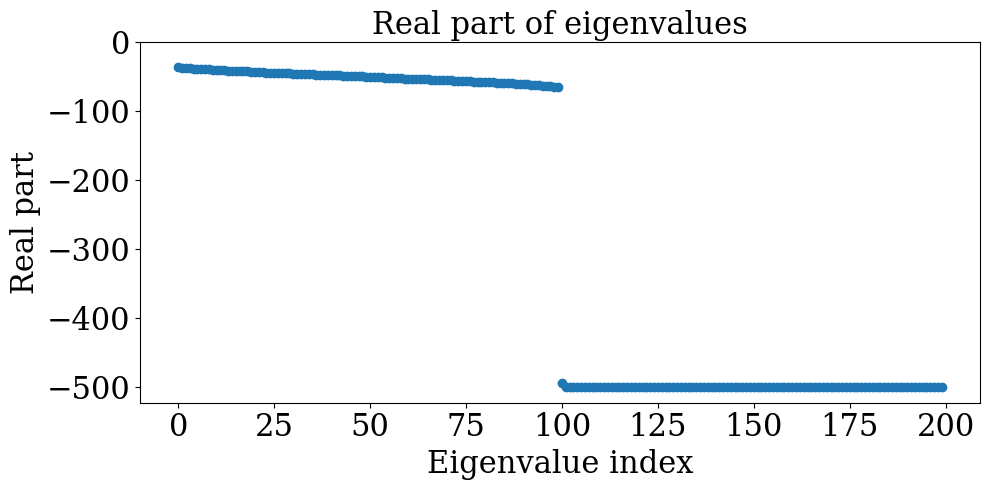

In [22]:
# finding the separation of scales in the center manifold and stable regions
trial_idx = 0
delta_idx = 25
input_idx = 0
sample_eigval = eigvals[delta_idx, input_idx, trial_idx, :]
sample_eigval_real = sample_eigval.real
# order them in descending order
sample_eigval_real = np.sort(sample_eigval_real)[::-1]

print(f'delta: {delta_range[delta_idx]}, input: {input_range[input_idx]}')

# plot the real part of eigenvalues
plt.figure(figsize=(10, 5))
plt.plot(sample_eigval_real, 'o')
plt.xlabel('Eigenvalue index', fontsize=22)
plt.ylabel('Real part', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title('Real part of eigenvalues', fontsize=22)
# Let matplotlib autoscale the y-axis first
plt.autoscale(axis='y')

# Get the current lower limit
current_bottom, _ = plt.ylim()

# Set only the upper limit to 0, while retaining the autoscaled lower limit
plt.ylim(current_bottom, 0)

plt.tight_layout()
plt.show()

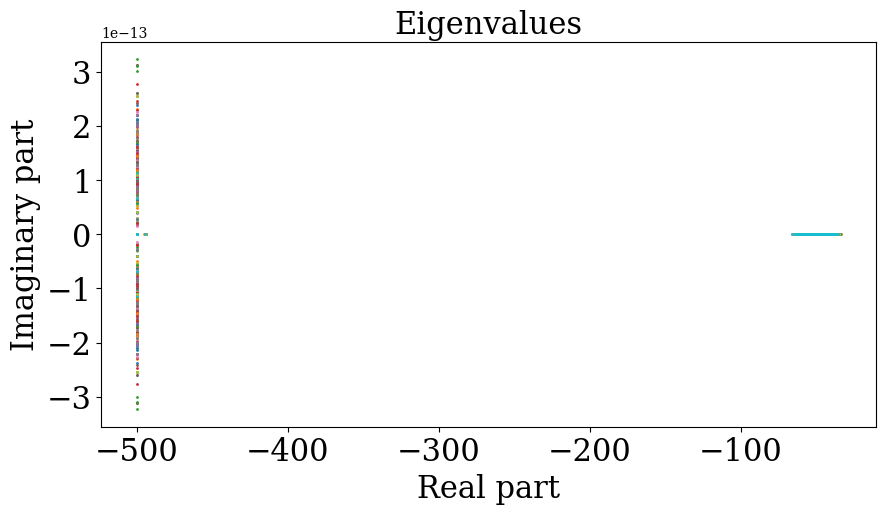

In [23]:
# plot all the eigenvals with x axis a real part and y axis as imaginary part
plt.figure(figsize=(10, 5))
for i in range(num_trials):
    sample_eigval = eigvals[delta_idx, input_idx, i, :]
    sample_eigval_real = sample_eigval.real
    sample_eigval_imag = sample_eigval.imag
    plt.scatter(sample_eigval_real, sample_eigval_imag, s=1)
plt.xlabel('Real part', fontsize=22)
plt.ylabel('Imaginary part', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title('Eigenvalues', fontsize=22)
plt.show()

delta: 0.01414991297434576, input: 0.012603829296797273


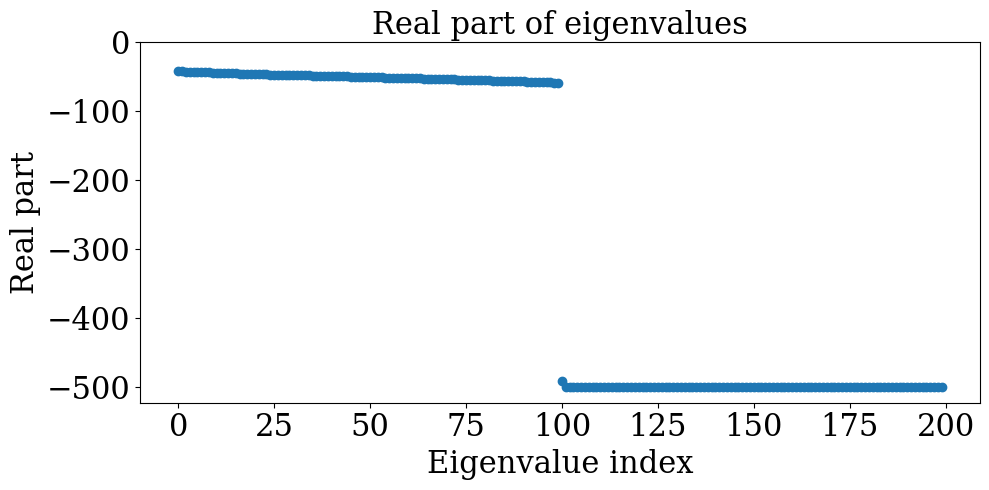

In [24]:
# finding the separation of scales in the center manifold and stable regions
delta_idx = 10
input_idx = 10
trial_idx = 0
sample_eigval = eigvals[delta_idx, input_idx, trial_idx, :]
sample_eigval_real = sample_eigval.real
sample_eigval_real = np.sort(sample_eigval_real)[::-1]

print(f'delta: {delta_range[delta_idx]}, input: {input_range[input_idx]}')

# plot the real part of eigenvalues
plt.figure(figsize=(10, 5))
plt.plot(sample_eigval_real, 'o')
plt.xlabel('Eigenvalue index', fontsize=22)
plt.ylabel('Real part', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title('Real part of eigenvalues', fontsize=22)
plt.tight_layout()

# Let matplotlib autoscale the y-axis first
plt.autoscale(axis='y')

# Get the current lower limit
current_bottom, _ = plt.ylim()

# Set only the upper limit to 0, while retaining the autoscaled lower limit
plt.ylim(current_bottom, 0)
plt.show()

### Frequency of oscillations

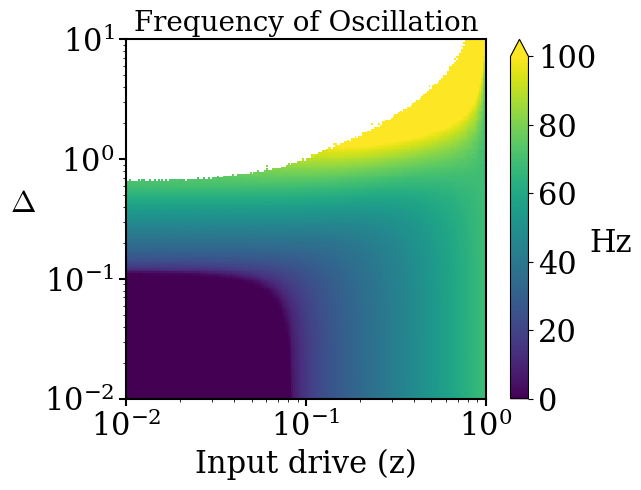

In [25]:
# Compute the maximum oscillatory frequency (absolute value of imaginary part) for each trial
# Here we take the maximum over the eigenvalue index


nan_in_slice_mask = torch.any(torch.isnan(eigvals), dim=3)
max_freq_each_trial = (1 / (2 * np.pi)) * torch.max(torch.abs(eigvals.imag), dim=3)[0]  # shape: (num_delta, num_input, num_trials)
max_freq_each_trial = torch.where(nan_in_slice_mask, torch.nan, max_freq_each_trial)

# Average over trials to get a 2D phase diagram (if desired)
max_freq_avg = torch.nanmean(max_freq_each_trial, dim=2)      # shape: (num_delta, num_input)
# Calculate the standard deviation
max_freq_std = utils.nanstd(max_freq_each_trial, dim=2)

# Convert to NumPy for plotting
max_freq_avg_np = max_freq_avg.numpy()
max_freq_std_np = max_freq_std.numpy()

# Determine vmin and vmax ignoring NaN values
vmin = np.nanmin(max_freq_avg_np)
# vmax = np.nanmax(max_freq_avg_np)
vmax = 100.0

# Plot the phase diagram for frequency using a sequential colormap ("viridis")
plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, max_freq_avg_np, cmap='viridis', norm=norm)
# plt.plot(new_input_norm, delta_c, color='k', linewidth=2.0, label=r'$\Delta_c$')

colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04, extend='max')

# Increase tick label size
colorbar.ax.tick_params(labelsize=22)

# Set the axis label
colorbar.set_label('Hz', fontsize=22, rotation=0, labelpad=10)

plt.xlabel('Input drive (z)', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("Frequency of Oscillation", fontsize=20)

# Create a colorbar and set a desired number of ticks (e.g., 10 ticks)

ax = plt.gca()

box_line_width = 1.5 # Adjust thickness as needed
for spine in ax.spines.values():
    spine.set_linewidth(box_line_width)

ax.tick_params(
    axis='both',
    which='major',
    labelsize=22,
    width=1.5,    # tick thickness
    length=5.0    # tick length
)
    
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])


file_name = f'freq_oscillation_{input_type}'
file_save_path = os.path.join(folder_loc, file_name)

plt.tight_layout()
plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()

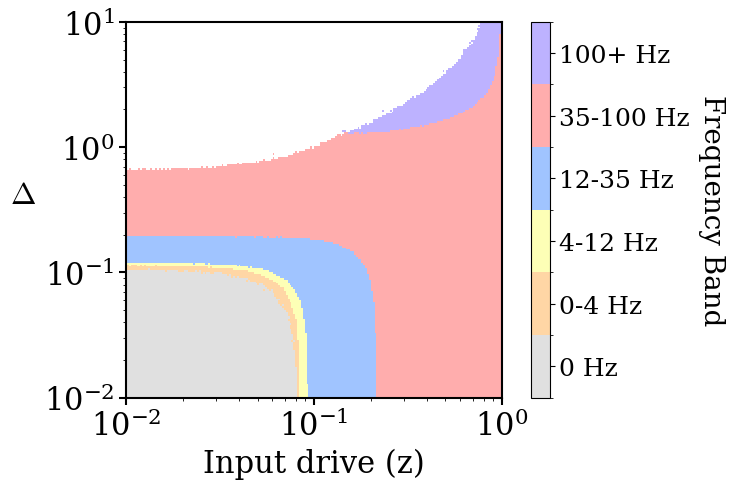

In [26]:
# --- Start of the MODIFIED plotting code ---
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np # Assuming numpy is used for input_range, delta_range, max_freq_avg_np
import os # Assuming os is used for saving

plt.figure(figsize=(7.5, 5))

# Define frequency bands boundaries
eps = 1e-6
plot_vmax = 150
if plot_vmax <= 100:
    plot_vmax = 101
# 7 boundaries define 6 intervals/colors
boundaries = [0, eps, 4, 12, 35, 100, plot_vmax]

# *** MODIFICATION HERE: Define your custom hex colors ***
# Define a list of hex color strings.
# The number of colors MUST match the number of intervals (len(boundaries) - 1).
# In this case, you need exactly 6 colors.
custom_hex_colors = [
    '#E0E0E0',  # Color for ~0 Hz band (0 to eps)
    '#ffd6a5',  # Color for 0-4 Hz band (eps to 4)
    '#fdffb6',  # Color for 4-12 Hz band (4 to 12)
    '#a0c4ff',  # Color for 12-35 Hz band (12 to 35)
    '#ffadad',  # Color for 35-100 Hz band (35 to 100)
    '#bdb2ff'   # Color for 100+ Hz band (100 to plot_vmax)
]
# Example using different colors:
# custom_hex_colors = ['#d73027', '#fc8d59', '#fee090', '#e0f3f8', '#91bfdb', '#4575b4']

# --- Sanity Check ---
expected_num_colors = len(boundaries) - 1
if len(custom_hex_colors) != expected_num_colors:
    raise ValueError(f"Error: Number of custom hex colors ({len(custom_hex_colors)}) "
                     f"does not match the required number of intervals ({expected_num_colors}) "
                     f"defined by the boundaries.")
# --- End Sanity Check ---

# Create the ListedColormap directly from your hex codes list
cmap = mcolors.ListedColormap(custom_hex_colors)
# **********************************************************

# Create the BoundaryNorm using the boundaries and the number of colors in the custom cmap
norm = mcolors.BoundaryNorm(boundaries, cmap.N)

# Plot the phase diagram using the custom colormap and norm
mesh = plt.pcolormesh(input_range, delta_range, max_freq_avg_np, cmap=cmap, norm=norm, shading='auto')

# Define tick labels (should match the number of colors/intervals)
tick_labels = ['0 Hz', '0-4 Hz', '4-12 Hz', '12-35 Hz', '35-100 Hz', '100+ Hz']

# Create colorbar
colorbar = plt.colorbar(mesh, spacing='uniform', boundaries=boundaries)

# Calculate numerical midpoints for tick locations
tick_locs_calculated = []
for i in range(len(boundaries) - 1):
    b_low = float(boundaries[i])
    b_high = float(boundaries[i+1])
    # For the first tiny interval, place the tick slightly offset if needed for visibility
    if i == 0 and eps > 0:
         midpoint = eps / 2.0 # Or adjust as needed visually
    else:
         midpoint = (b_low + b_high) / 2.0
    tick_locs_calculated.append(midpoint)


# Explicitly set the ticks and labels
colorbar.set_ticks(tick_locs_calculated)
colorbar.set_ticklabels(tick_labels)

# Increase tick label size
colorbar.ax.tick_params(labelsize=18)

# Set the axis label for the colorbar
colorbar.set_label('Frequency Band', fontsize=20, rotation=270, labelpad=25)

plt.xlabel('Input drive (z)', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15) # Use raw string for LaTeX
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# plt.title("Frequency of Oscillation Bands", fontsize=20)

# --- Rest of your formatting code ---
# (Keep the axis setup, saving etc. the same as in your original code)
ax = plt.gca()
box_line_width = 1.5
for spine in ax.spines.values():
    spine.set_linewidth(box_line_width)
ax.tick_params(axis='both', which='major', labelsize=22, width=1.5, length=5.0)

# Add robustness for log scale calculations
if delta_scale == 'log-scale':
    plt.yscale('log')
    # Find the smallest positive value in delta_range for safe log calculation
    positive_deltas = delta_range[delta_range > 0]
    safe_delta_min = positive_deltas[0] if len(positive_deltas) > 0 else 1e-9 # Default if no positive values
    if delta_range[-1] > safe_delta_min:
        y_span = np.log10(delta_range[-1]) - np.log10(safe_delta_min)
    else: y_span = 0 # Avoid log errors if max <= min
else:
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
# Find the smallest positive value in input_range for safe log calculation
positive_inputs = input_range[input_range > 0]
safe_input_min = positive_inputs[0] if len(positive_inputs) > 0 else 1e-9 # Default if no positive values
if input_range[-1] > safe_input_min:
    x_span = np.log10(input_range[-1]) - np.log10(safe_input_min)
else: x_span = 0 # Avoid log errors if max <= min


# Adjust aspect ratio only if both spans are positive and non-zero
if y_span > 1e-9 and x_span > 1e-9: # Use small tolerance instead of > 0 for float comparisons
    ax.set_aspect(x_span / y_span, adjustable='box')
# Optional: handle cases where one span might be zero (e.g., constant axis), though less likely with log scales
# elif y_span > 1e-9:
#      ax.set_aspect(1.0 / y_span, adjustable='box')
# elif x_span > 1e-9:
#      ax.set_aspect(x_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])
os.makedirs(folder_loc, exist_ok=True)
file_name = f'freq_oscillation_bands_{input_type}'
file_save_path = os.path.join(folder_loc, file_name)
plt.tight_layout()
plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight')
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight') # Saving EPS can sometimes have issues, uncomment if needed
plt.show()

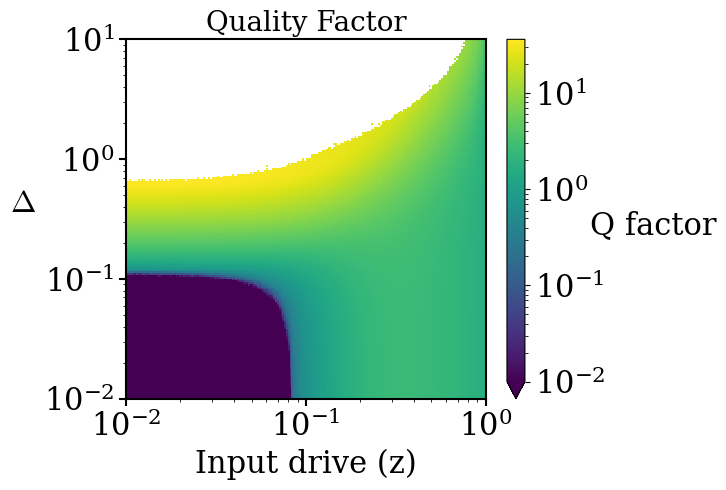

In [77]:
import matplotlib.colors as mcolors


# Compute the quality factor for each trial.
max_imag_each_trial, max_idx = torch.max(torch.abs(eigvals.imag), dim=3)
max_real_each_trial = torch.gather(eigvals.real, 3, max_idx.unsqueeze(-1)).squeeze(-1)
epsilon = 1e-12 # Small number to prevent division by absolute zero
quality_each_trial = max_imag_each_trial / (torch.abs(max_real_each_trial) + epsilon)
# Replace potential infinities/NaNs
quality_each_trial = torch.nan_to_num(quality_each_trial, nan=torch.nan, posinf=torch.nan, neginf=torch.nan)

# Average over trials
quality_avg = torch.nanmean(quality_each_trial, dim=2)
# Calculate the standard deviation
quality_std = utils.nanstd(quality_each_trial, dim=2)

# Convert to NumPy for plotting
quality_avg_np = quality_avg.numpy()
quality_std_np = quality_std.numpy()


plt.figure(figsize=(7.5, 5))

# Determine vmax ignoring NaN values
vmax = np.nanmax(quality_avg_np)
if not np.isfinite(vmax):
    vmax = 1.0
    print("Warning: vmax is non-finite. Setting vmax=1.0")

# Define a lower threshold for the logarithmic scale. MUST be > 0.
vmin_log = 0.01  # Example threshold: ADJUST THIS VALUE AS NEEDED!

# Create the logarithmic normalization
norm = mcolors.LogNorm(vmin=vmin_log, vmax=vmax, clip=False)
# --- Plotting ---
mesh = plt.pcolormesh(input_range, delta_range, quality_avg_np, cmap='viridis', norm=norm, shading='auto')

# Create the colorbar using the final calculated ticks
colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04, ticks=None, extend='min')


colorbar.ax.tick_params(labelsize=22)
colorbar.set_label('Q factor', fontsize=22, rotation=0, labelpad=35)

# --- Axes Labels, Scales, Aspect Ratio, Saving ---
plt.xlabel('Input drive (z)', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("Quality Factor", fontsize=20)

ax = plt.gca()

box_line_width = 1.5 # Adjust thickness as needed
for spine in ax.spines.values():
    spine.set_linewidth(box_line_width)

ax.tick_params(
    axis='both',
    which='major',
    labelsize=22,
    width=1.5,    # tick thickness
    length=5.0    # tick length
)

if delta_scale == 'log-scale':
    plt.yscale('log')
    try: y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
    except (ValueError, IndexError, TypeError): y_span = 1.0
else:
    try: y_span = delta_range[-1] - delta_range[0]
    except (IndexError, TypeError): y_span = 1.0

plt.xscale('log')
try: x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
except (ValueError, IndexError, TypeError): x_span = 1.0

if x_span > 0 and y_span > 0:
    ax.set_aspect(x_span / y_span, adjustable='box')
else:
    print("Warning: Could not calculate valid x_span/y_span for aspect ratio.")

if input_range is not None and len(input_range) > 1: plt.xlim([input_range[0], input_range[-1]])
if delta_range is not None and len(delta_range) > 1: plt.ylim([delta_range[0], delta_range[-1]])

file_name = f'quality_factor_{input_type}_logcolor'
file_save_path = os.path.join(folder_loc, file_name)

plt.tight_layout()
plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300) 

plt.show()